## 1 - Import

In [288]:
from rosbags.rosbag1 import Reader
from rosbags.typesys import Stores, get_typestore
from ahrs import Quaternion
from ahrs.filters import Madgwick
import numpy as np
import matplotlib.pyplot as plt
from state import SystemState, System

# Create a typestore and get the string class.
typestore = get_typestore(Stores.ROS1_NOETIC)

# specific force from accelerometer
f_x = []
f_y = []
f_z = []

# angular velocity from gyroscope
w_x = []
w_y = []
w_z = []

ts = []


# Quaternion representation of attitude
q = []



# Create reader instance and open for reading.
with Reader('2024-03-26-12-56-42.bag') as reader:
    # Topic and msgtype information is available on .connections list.
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

        # Iterate over messages.
    for connection, timestamp, rawdata in reader.messages():
        
        if connection.topic == '/ros/imu':
            ts.append(timestamp)
            msg = typestore.deserialize_ros1(rawdata, connection.msgtype)
            f_x.append(msg.linear_acceleration.x)
            f_y.append(msg.linear_acceleration.y)
            f_z.append(msg.linear_acceleration.z)

            q.append(Quaternion([msg.orientation.w, msg.orientation.x, msg.orientation.y, msg.orientation.z]))
            
            w_x.append(msg.angular_velocity.x)
            w_y.append(msg.angular_velocity.y)
            w_z.append(msg.angular_velocity.z)



/rosout rosgraph_msgs/msg/Log
/ros/imu sensor_msgs/msg/Imu


## 2 - Preprocessing

### 2.1 - Convert timestamps to time (s) and Determine discrete time step size in sec

In [289]:
# convert ts to seconds relative to start
t = np.array(ts)
t = (t - t[0]) * 1e-9

# determine step times
dt = np.diff(t).mean()
print("Mean step time period (s):", dt)
print("Approximate sampling frequency (Hz):", int(1/dt))


Mean step time period (s): 0.004862875002116975
Approximate sampling frequency (Hz): 205


### 2.2 - Plot raw accelerometer data

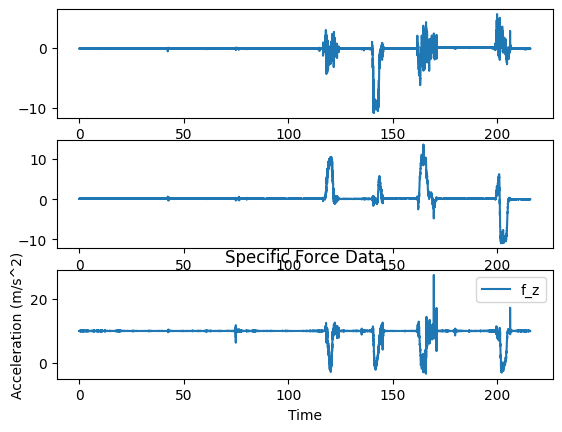

In [290]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(t, f_x, label='f_x')
plt.subplot(3,1,2)
plt.plot(t, f_y, label='f_y')
plt.subplot(3,1,3)
plt.plot(t, f_z, label='f_z')
plt.legend()
plt.title('Specific Force Data')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.show()

### 2.3 - Plot orientation data (from rosbag message data store)

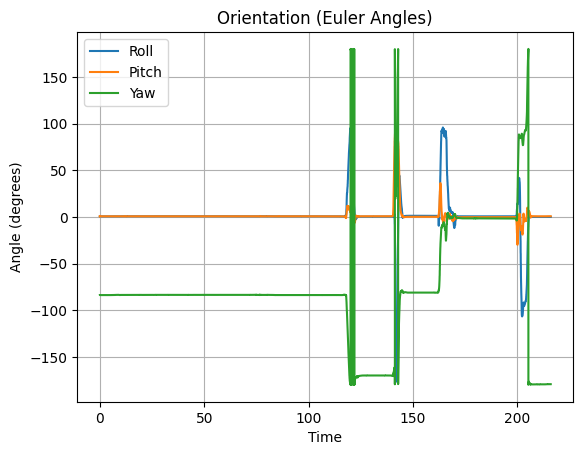

In [291]:
RollPitchYaw = np.degrees(np.array([quat.to_angles() for quat in q]))
roll = RollPitchYaw[:, 0]
pitch = RollPitchYaw[:, 1]
yaw = RollPitchYaw[:, 2]

plt.figure()
plt.plot(t, roll, label='Roll')
plt.plot(t, pitch, label='Pitch')
plt.plot(t, yaw, label='Yaw')
plt.legend()
plt.title('Orientation (Euler Angles)')
plt.xlabel('Time')
plt.ylabel('Angle (degrees)')
plt.grid()
plt.show()

### 2.4 Subtract gravity (g) from accelerometer data
- Transform g vector from navigation frame to IMU frame using orientation data
- Subtract transformed g_imu vector from accelerometer data

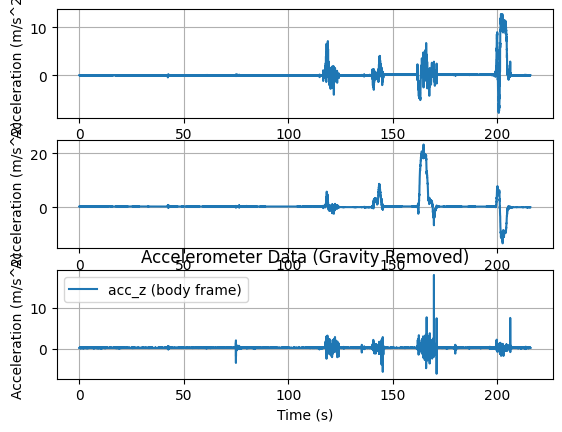

In [292]:
# Convert lists to numpy arrays
f_x = np.array(f_x)
f_y = np.array(f_y)
f_z = np.array(f_z)

q = np.array(q)
g_nav = np.array([0, 0, 9.81])

# Initialize output arrays
acc_x = np.zeros(len(f_x))
acc_y = np.zeros(len(f_y))
acc_z = np.zeros(len(f_z))

# Subtract gravity from specific force
for i in range(len(f_x)):
    quat = Quaternion(q[i])
    # Measured acceleration in body frame
    acc_imu = np.array([f_x[i], f_y[i], f_z[i]])
    # Gravity rotated to body frame
    g_imu = quat.rotate(g_nav)
    # True acceleration in body frame (gravity removed)
    acc_x[i] = acc_imu[0] - g_imu[0]
    acc_y[i] = acc_imu[1] - g_imu[1]
    acc_z[i] = acc_imu[2] - g_imu[2]

# Plot accelerometer data
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t, acc_x, label='acc_x (body frame)')
plt.ylabel('Acceleration (m/s^2)')
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(t, acc_y, label='acc_y (body frame)')
plt.ylabel('Acceleration (m/s^2)')
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(t, acc_z, label='acc_z (body frame)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.grid()
plt.legend()
plt.title('Accelerometer Data (Gravity Removed)')
plt.show()

### 2.5 - Bias estimation for accelerometer
- Use samples from stationary moments and approximate bias of accelerometer
- Mean values can be used for this simple example

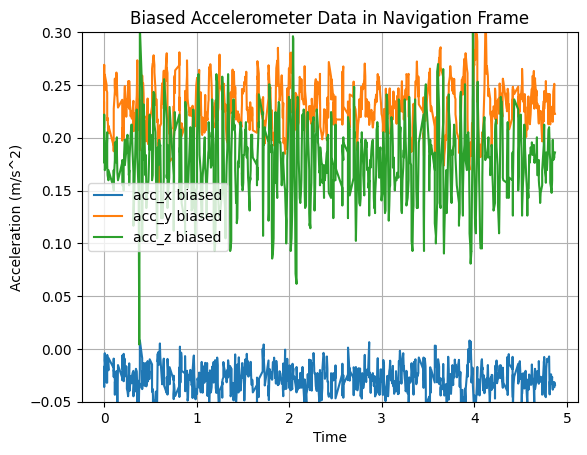

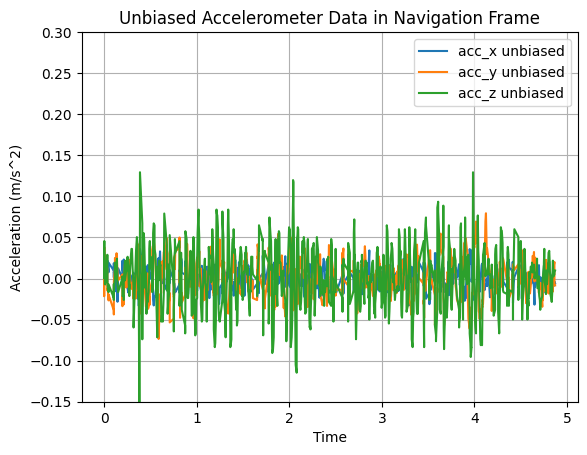

In [293]:
bias_acc_x = np.mean(acc_x[:1000])
bias_acc_y = np.mean(acc_y[:1000])
bias_acc_z = np.mean(acc_z[:1000])

acc_unbiased_x = acc_x - bias_acc_x
acc_unbiased_y = acc_y - bias_acc_y
acc_unbiased_z = acc_z - bias_acc_z

plt.figure()
plt.plot(t[:1000], acc_x[:1000], label='acc_x biased')
plt.plot(t[:1000], acc_y[:1000], label='acc_y biased')
plt.plot(t[:1000], acc_z[:1000], label='acc_z biased')
plt.legend()
plt.title('Biased Accelerometer Data in Navigation Frame')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.ylim([-0.05, 0.30])
plt.grid()
plt.show()


plt.figure()
plt.plot(t[:1000], acc_unbiased_x[:1000], label='acc_x unbiased')
plt.plot(t[:1000], acc_unbiased_y[:1000], label='acc_y unbiased')
plt.plot(t[:1000], acc_unbiased_z[:1000], label='acc_z unbiased')
plt.legend()
plt.title('Unbiased Accelerometer Data in Navigation Frame')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.ylim([-0.15, 0.30])
plt.grid()
plt.show()


## 2.6 Measurement Error - Standard Deviation of the Accelerometer

In [294]:
R_x = acc_unbiased_x[:1000].var()
R_y = acc_unbiased_y[:1000].var()
R_z = acc_unbiased_z[:1000].var()

print("Accelerometer Measurement Noise Variance:")
print("R_x:", R_x)
print("R_y:", R_y)
print("R_z:", R_z)

Accelerometer Measurement Noise Variance:
R_x: 0.00015087217228103737
R_y: 0.0005027574127659284
R_z: 0.0014106823998799633


## 3 - Applying Simple Kalman Filter to Biased Accelerometer Data

### 3.1 - Initial Setup For Kalman

In [285]:
x_0 = np.zeros(9)  # Initial position, velocity and acceleration
P_0 = np.eye(9) * 0.01  # Initial covariance matrix

state_0 = SystemState(x_0, P_0)
system = System(state_0, 0.5)

### 3.2 - Measurement Model (Accelerometer)

In [286]:
H = np.zeros((3, 9))
H[:,6:9] = np.eye(3)

# Measurement Noise Covariance Matrix
R = np.diag([R_x, R_y, R_z])
print("H matrix:")
print(H)
print("R matrix:")
print(R)    

H matrix:
[[0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
R matrix:
[[0.00015087 0.         0.        ]
 [0.         0.00050276 0.        ]
 [0.         0.         0.00141068]]


### 3.3 - Kalman Processing Loop
- Biased Accelerations

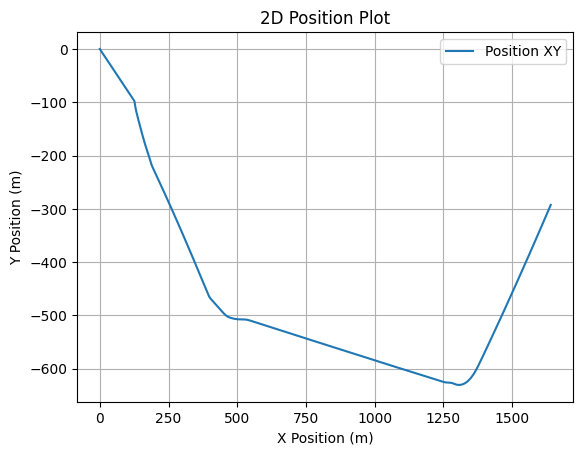

In [287]:
positions = []
velocities = []
accelerations = []


for i in range(len(t)):
    # Prediction step
    system.propagate(dt)
    # Rotate accelerations to navigation frame
    quat = Quaternion(q[i])
    # a = np.array([acc_x[i], acc_y[i], acc_z[i]])
    a = quat.rotate(np.array([acc_unbiased_x[i], acc_unbiased_y[i], acc_unbiased_z[i]]))
    # Measurement vector
    z = np.array([a[0], a[1], a[2]])

    # Update step
    system.update(z, H, R)

    x = system.state_plus.x
    # Store results
    positions.append(x[0:3].copy())
    velocities.append(x[3:6].copy())
    accelerations.append(x[6:9].copy())

positions = np.array(positions)
velocities = np.array(velocities)
accelerations = np.array(accelerations)

plt.figure()
plt.plot(positions[:, 0], positions[:, 1], label='Position XY')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('2D Position Plot')
plt.legend()
plt.grid()
plt.show()